# Face Generation

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms
%matplotlib inline

## Create a DataLoader

In [2]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()]) 
    image_dataset = datasets.ImageFolder(data_dir, transform)
    return torch.utils.data.DataLoader(image_dataset, batch_size = batch_size, shuffle=True)

In [3]:
# Define function hyperparameters
batch_size = 128
img_size = 32
data_dir = 'processed_celeba_small/'
celeba_train_loader = get_dataloader(batch_size, img_size)


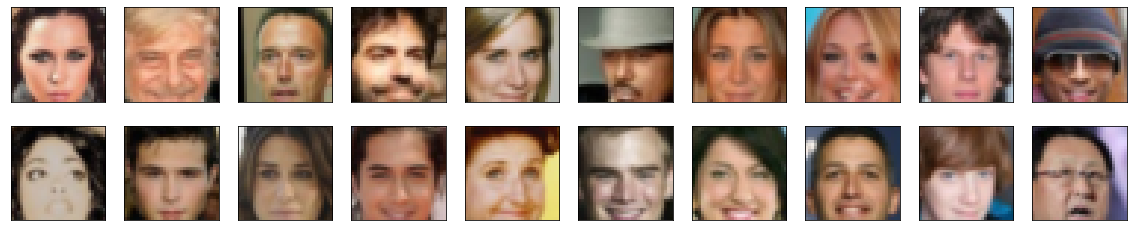

In [4]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-processing image data and scale it to a pixel range of -1 to 1

In [5]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    min,max = feature_range
    return x *(max - min)+min


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator


In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
       # self.in : (32,32,3)
        self.conv_dim = conv_dim
        self.disc = nn.Sequential(
            nn.Conv2d(3,conv_dim,kernel_size = 4, stride=2, padding = 1),
            nn.BatchNorm2d(conv_dim),
            nn.LeakyReLU(negative_slope = 0.2),
            
            nn.Conv2d(conv_dim,conv_dim*2,kernel_size = 4, stride=2, padding = 1),
            nn.BatchNorm2d(conv_dim*2),
            nn.LeakyReLU(negative_slope = 0.2),
            
            nn.Conv2d(conv_dim*2,conv_dim*4,kernel_size = 4, stride=2, padding = 1),
            nn.BatchNorm2d(conv_dim*4),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Conv2d(conv_dim*4,conv_dim*8,kernel_size = 4, stride=2, padding = 1),
        )
        self.classifier = nn.Linear(conv_dim*8*2*2,1)
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """       
        disc_pred = self.disc(x)
        disc_pred = disc_pred.view(-1, self.conv_dim*8*2*2)
        disc_pred = self.classifier(disc_pred)
        return disc_pred



## Generator

In [8]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        self.gen = nn.Sequential(
            
            nn.ConvTranspose2d(conv_dim*8,conv_dim*4, kernel_size=4, stride=2,padding=1,),
            nn.BatchNorm2d(conv_dim*4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(conv_dim*4,conv_dim*2, kernel_size=4, stride=2,padding=1,),
            nn.BatchNorm2d(conv_dim*2),
            nn.ReLU(),
            
            
            nn.ConvTranspose2d(conv_dim*2,conv_dim, kernel_size=4, stride=2,padding=1,),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(),
            
            
            nn.ConvTranspose2d(conv_dim,3, kernel_size=4, stride=2,padding=1,),
            nn.Tanh()         
            
        )


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8,2, 2)
        gen_pred =  self.gen(out)
        return gen_pred

## Initialize the weights of your networks

In [9]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model: convolutional and linear
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    isConvolution = classname.find('Conv') != -1
    isLinear = classname.find('Linear') != -1
    if (hasattr(m, 'weight') and isConvolution or isLinear):
        init.normal_(m.weight.data, 0.0, 0.02)

## Build complete network


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    return D, G


#### Define model hyperparameters

In [11]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (classifier): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (gen): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm

### Training on GPU


In [12]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

In [13]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers


In [14]:
import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. 

In [15]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            g_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [16]:
# set number of epochs 
n_epochs = 2

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/    2] | d_loss: 1.6605 | g_loss: 3.7347
Epoch [    1/    2] | d_loss: 0.0654 | g_loss: 4.6064
Epoch [    1/    2] | d_loss: 0.3951 | g_loss: 3.9124
Epoch [    1/    2] | d_loss: 0.3483 | g_loss: 6.7650
Epoch [    2/    2] | d_loss: 0.2720 | g_loss: 9.6141
Epoch [    2/    2] | d_loss: 0.1032 | g_loss: 6.7605
Epoch [    2/    2] | d_loss: 0.0360 | g_loss: 6.2946
Epoch [    2/    2] | d_loss: 0.0353 | g_loss: 5.8593


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

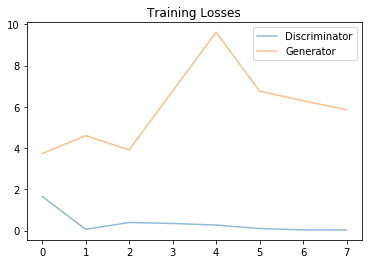

In [17]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [18]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [19]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

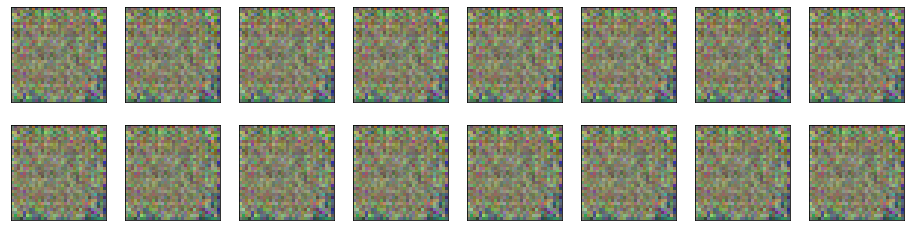

In [20]:
_ = view_samples(-1, samples)